In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict

In [18]:
imu = pd.read_csv('training_data/subject_001_01__x.csv',
                  names=['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'])
imu_t = pd.read_csv('training_data/subject_001_01__x_time.csv', names=['time'])
ann = pd.read_csv('training_data/subject_001_01__y.csv', names=['labels'])
ann_t = pd.read_csv('training_data/subject_001_01__y_time.csv', names=['time'])

In [19]:
def expand_ann(imu_t:list, ann:list, ann_t:list) -> Dict[str, list]:
    class MemIter():
        def __init__(self, v:list):
            self.v = v
            self.i = 0
            self.val = v[self.i]
            
        def increment(self):
            self.i += 1
            self.val = self.v[self.i]


    mem_ann = MemIter(ann)
    mem_ann_t = MemIter(ann_t)

    ann_out = []
    for i, curr_imu_time in enumerate(imu_t):
        
        if curr_imu_time < mem_ann_t.val:
            ann_out.append(mem_ann.val)
            
        else:
            ann_out.append(mem_ann.val)
            if i != len(imu) - 1: # Don't increment if last element
                mem_ann.increment()
                mem_ann_t.increment()
                
    return {
        'ann': ann_out,
        'ann_time': imu_t
    }

In [20]:
expanded_ann = expand_ann(
    imu_t['time'].tolist(),
    ann['labels'].tolist(),
    ann_t['time'].tolist()
)

In [35]:
# Verify lengths are the same
assert len(expanded_ann['ann']) == len(imu)

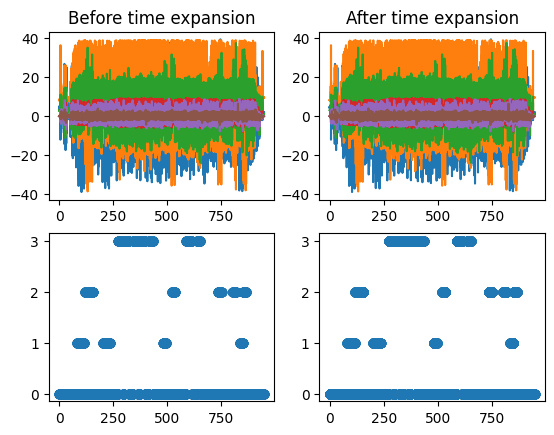

In [32]:
# Verify plots look the same
fig, axs = plt.subplots(2, 2)
axs[0][0].plot(imu_t, imu)
axs[0][0].set_title('Before time expansion')
axs[1][0].scatter(ann_t, ann)
axs[0][1].set_title('After time expansion')
axs[0][1].plot(imu_t, imu)
axs[1][1].scatter(expanded_ann['ann_time'], expanded_ann['ann'])
plt.show()